In [1]:
#|export
import torch

import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder


/scratch/users/carles/mambaforge/envs/mini-diffusers/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
from miniai.utils import set_seed, clean_ipython_hist, clean_tb, clean_mem
from miniai.datasets import DataLoaders, inplace
from miniai.conv import conv

from miniai.learner import MomentumLearner, DeviceCB, MetricsCB, ProgressCB, LRFinderCB, TrainLearner
from miniai.activations import ActivationStats
from miniai.init import GeneralRelu, init_weights, get_model
from miniai.sgd import RecorderCB, BatchSchedCB
from torch.optim import lr_scheduler


In [44]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [45]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [46]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

In [47]:
def _lr(cb): 
    return cb.pg['lr']

accuracy,loss,epoch,train
0.806,0.525,0,train
0.848,0.411,0,eval
0.879,0.330,1,train
0.879,0.329,1,eval
0.898,0.282,2,train
0.881,0.317,2,eval
0.900,0.274,3,train
0.882,0.315,3,eval
0.896,0.283,4,train
0.880,0.335,4,eval


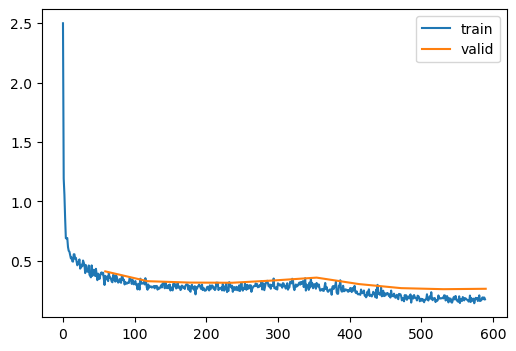

In [49]:
set_seed(42)

tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(10)

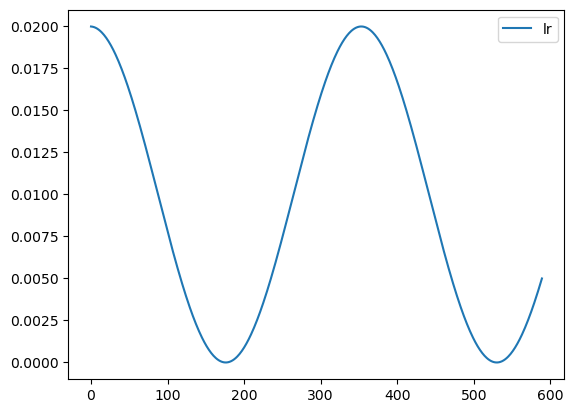

In [50]:
rec.plot()